In [1]:
cd /content/drive/MyDrive/Colab Notebooks/ポートフォリオ/crack_segmentation_dataset

/content/drive/MyDrive/Colab Notebooks/ポートフォリオ/crack_segmentation_dataset


In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [ ]:
import os, cv2, glob
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from albumentations.pytorch.transforms import ToTensor

import segmentation_models_pytorch as smp

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def show_image(img):
  plt.imshow(img)
  plt.show()

In [ ]:
test_img_paths = sorted(glob.glob("test/images/*.jpg"))
test_mask_paths = sorted(glob.glob("test/masks/*.jpg"))

In [ ]:
class_names = ['crack','background']
class_rgb_values = [[255,255,255], [0,0,0]]

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
get_train_transforms = album.Compose(
         [album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5)
        ], 
        p=1.0)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
WEIGHT_PATH = "weights/deeplabv3plus_1_best.pth"

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model.load_state_dict(torch.load(WEIGHT_PATH))

model.to(device)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
preprocess = get_preprocessing(preprocessing_fn)

In [ ]:
def IoU(pred_mask, truth_mask):   

  tp = np.count_nonzero((truth_mask ==1) & (pred_mask == 1))
  tn = np.count_nonzero((truth_mask ==0) & (pred_mask == 0))
  fn = np.count_nonzero((truth_mask ==1) & (pred_mask == 0))
  fp = np.count_nonzero((truth_mask ==0) & (pred_mask == 1))

  if (tp + fp + fn) == 0:
    iou = 100
    detect = 'All_TN'
  elif tp == 0 and fp == 0:
    iou = tp/(tp + fp + fn)*100
    detect = 'No_detect'
  elif tp == 0 and fn == 0:
    iou = tp/(tp + fp + fn)*100
    detect = 'Mis_detect'
  else:
    iou = tp/(tp + fp + fn)*100
    if iou == 0:
      detect = "NoMis_detect"
    else:
      detect = 'Detect'
  return iou, detect

In [ ]:
def make_gt_and_pred_mask(img_path, mask_path, thresh=0.5):
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  gt_mask = cv2.imread(mask_path, 0)

  sample = preprocess(image=image)
  input = torch.from_numpy(sample["image"]).unsqueeze(0).cuda().float()

  pred_mask = model.predict(input)[0,0,:,:].cpu().numpy()
  pred_mask = np.where(pred_mask>=thresh, 1, 0)

  gt_mask = np.where(gt_mask==255, 1, 0)

  return pred_mask, gt_mask

In [ ]:
result_list = [["Image_name", "IoU", "State"]]
for img_path, mask_path in zip(test_img_paths, test_mask_paths):
  pred_mask, gt_mask = make_gt_and_pred_mask(img_path, mask_path, thresh=0.5)
  iou, detect = IoU(pred_mask, gt_mask)
  save_name = img_path.replace("test/images", "")
  result_list.append([save_name, iou, detect])
pd_result = pd.DataFrame(result_list)

In [ ]:
save_result_name = "deeplabv3plus_0.csv"
pd_result.to_csv(save_result_name)

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

save_result_name = "deeplabv3plus_0.csv"
pd_result = pd.read_csv(save_result_name)

mIoU: 39.09303968875256


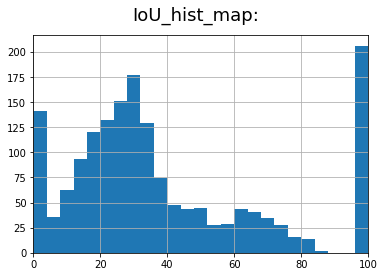

In [4]:
pd_IoU = pd_result.iloc[1:, 2].astype(float)

print("mIoU:", pd_IoU.mean())
pd_IoU.hist(bins=25)
plt.suptitle("IoU_hist_map:", size=18, weight=2)
plt.xlim(0, 100)
plt.show()

accuracy: 94.69026548672566 %


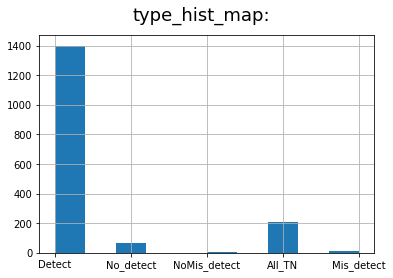

In [24]:
pd_type = pd_result.iloc[1:, 3]
print("accuracy:", ((pd_type == "Detect") | (pd_type == "All_TN")).sum()/len(pd_type) * 100, "%")
pd_type.hist()
plt.suptitle("type_hist_map:", size=18, weight=2)
plt.show()

In [22]:
((pd_type == "Detect") | (pd_type == "All_TN")).sum()

1605

In [14]:
pd_type == "Detect" | "All_TN"

TypeError: ignored